In [ ]:
import pandas as pd
data = pd.read_csv('oasis_longitudinal.csv')
data.head(5)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
data = data.loc[data['Visit']==1] # use first visit data only because of the analysis we're doing
data = data.reset_index(drop=True) # reset index after filtering first visit data
data['M/F'] = data['M/F'].replace(['F','M'], [0,1]) # M/F column
data['Group'] = data['Group'].replace(['Converted'], ['Demented']) # Target variable
data['Group'] = data['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
data = data.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

In [ ]:
data.shape

(150, 12)

In [ ]:
data.head(5)

,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,1,0,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,0,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,0,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,1,0,1,71,16,NaN,28.0,0.5,1357,0.748,1.293


Text(0.5, 1.0, 'Gender and Demented rate')

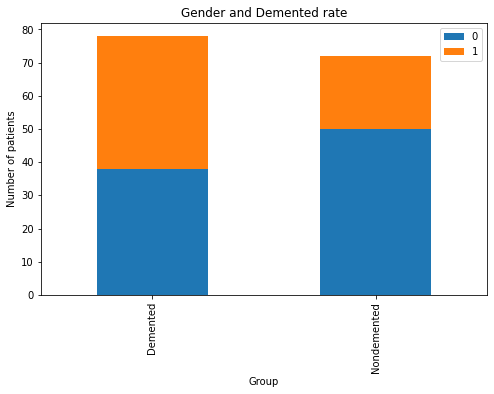

In [ ]:
import matplotlib.pyplot as plt
# bar drawing function
def bar_chart(feature):
    Demented = data[data['Group']==1][feature].value_counts()
    Nondemented = data[data['Group']==0][feature].value_counts()
    data_bar = pd.DataFrame([Demented,Nondemented])
    data_bar.index = ['Demented','Nondemented']
    data_bar.plot(kind='bar',stacked=True, figsize=(8,5))
# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')

In [ ]:
features= data.iloc[:,5:12]
var= features.var()
std =  features.std()
max=  features.max()
min= features.min()
mean= features.mean()
median = features.median()
pd.DataFrame({'features':['EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
             'variance': var,
              'std':std,
              'max':max,
              'min':min,
              'mean':mean,
              'median':median})

,features,variance,std,max,min,mean,median
EDUC,EDUC,8.263982,2.874714,23.000,6.000,14.533333,14.0000
SES,SES,1.273000,1.128273,5.000,1.000,2.492958,2.0000
MMSE,MMSE,8.811812,2.968470,30.000,17.000,27.560000,29.0000
CDR,CDR,0.106443,0.326256,1.000,0.000,0.260000,0.0000
eTIV,eTIV,30514.461029,174.683889,1987.000,1123.000,1474.426667,1453.5000
nWBV,nWBV,0.001329,0.036458,0.837,0.660,0.736073,0.7350
ASF,ASF,0.019007,0.137864,1.563,0.883,1.206333,1.2075


In [ ]:
#replace null values with their median for performance
data["SES"].fillna(data.groupby("EDUC")["SES"].transform("median"), inplace=True)
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(data['SES']).value_counts()

False    150
Name: SES, dtype: int64

In [ ]:
#MODEL PERFORMANCE
# Splitting Train/Validation/Test Sets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 

# Dataset with imputation
Y = data['Group'].values # Target for the model
X = data[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.25, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian = gaussian.fit(X_train_scaled,Y_train)
predicted = gaussian.predict(X_test_scaled)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score, roc_curve, auc
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("classification_report is :\n",classification_report(Y_test, predicted)) # Full set accuracy
print("confusion_matrix is \n", confusion_matrix(Y_test,predicted))

Accuracy: 0.7894736842105263
classification_report is :
               precision    recall  f1-score   support

           0       0.71      0.94      0.81        18
           1       0.93      0.65      0.76        20

    accuracy                           0.79        38
   macro avg       0.82      0.80      0.79        38
weighted avg       0.82      0.79      0.79        38

confusion_matrix is 
 [[17  1]
 [ 7 13]]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
 # Create Decision Tree classifer object
clf = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf = clf.fit(X_train_scaled,Y_train)

#Predict the response for test dataset
predicted = clf.predict(X_test_scaled)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("classification_report is :\n",classification_report(Y_test, predicted)) # Full set accuracy
print("confusion_matrix is \n", confusion_matrix(Y_test,predicted))

Accuracy: 0.6842105263157895
classification_report is :
               precision    recall  f1-score   support

           0       0.65      0.72      0.68        18
           1       0.72      0.65      0.68        20

    accuracy                           0.68        38
   macro avg       0.69      0.69      0.68        38
weighted avg       0.69      0.68      0.68        38

confusion_matrix is 
 [[13  5]
 [ 7 13]]


In [ ]:
pip install graphviz

In [ ]:
#svm
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc =svc .fit(X_train_scaled, Y_train)
#Predict the response for test dataset
predicted = svc.predict(X_test_scaled)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("classification_report is :\n",classification_report(Y_test, predicted)) # Full set accuracy
print("confusion_matrix is \n", confusion_matrix(Y_test,predicted))

Accuracy: 0.7631578947368421
classification_report is :
               precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.87      0.65      0.74        20

    accuracy                           0.76        38
   macro avg       0.78      0.77      0.76        38
weighted avg       0.79      0.76      0.76        38

confusion_matrix is 
 [[16  2]
 [ 7 13]]


In [ ]:
#bagging
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(base_estimator=SVC(kernel='poly',gamma=0.8), n_estimators=5, random_state=5)
bagging = bagging.fit(X_train_scaled, Y_train)
#Predict the response for test dataset
predicted = svc.predict(X_test_scaled)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("classification_report is :\n",classification_report(Y_test, predicted)) # Full set accuracy
print("confusion_matrix is \n", confusion_matrix(Y_test,predicted))

Accuracy: 0.7631578947368421
classification_report is :
               precision    recall  f1-score   support

           0       0.70      0.89      0.78        18
           1       0.87      0.65      0.74        20

    accuracy                           0.76        38
   macro avg       0.78      0.77      0.76        38
weighted avg       0.79      0.76      0.76        38

confusion_matrix is 
 [[16  2]
 [ 7 13]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
#create random forest classifier and fit the values
model= RandomForestClassifier(n_estimators=10, max_features=7, max_depth=5, random_state=0)
rfclassifier = model.fit(X_train_scaled, Y_train )
#Predict the response for test dataset
predicted = rfclassifier.predict(X_test_scaled)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("classification_report is :\n",classification_report(Y_test, predicted)) # Full set accuracy
print("confusion_matrix is \n", confusion_matrix(Y_test,predicted))

Accuracy: 0.868421052631579
classification_report is :
               precision    recall  f1-score   support

           0       0.78      1.00      0.88        18
           1       1.00      0.75      0.86        20

    accuracy                           0.87        38
   macro avg       0.89      0.88      0.87        38
weighted avg       0.90      0.87      0.87        38

confusion_matrix is 
 [[18  0]
 [ 5 15]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=11, random_state=0)
adaboost = adaboost.fit(X_train_scaled, Y_train)
#Predict the response for test dataset
predicted = adaboost.predict(X_test_scaled)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, predicted))
print("classification_report is :\n",classification_report(Y_test, predicted)) # Full set accuracy
print("confusion_matrix is \n", confusion_matrix(Y_test,predicted))

Accuracy: 0.8157894736842105
classification_report is :
               precision    recall  f1-score   support

           0       0.72      1.00      0.84        18
           1       1.00      0.65      0.79        20

    accuracy                           0.82        38
   macro avg       0.86      0.82      0.81        38
weighted avg       0.87      0.82      0.81        38

confusion_matrix is 
 [[18  0]
 [ 7 13]]


In [ ]:
from xgboost import  XGBClassifier
model = XGBClassifier()
model.fit(X_train_scaled, Y_train)
# make predictions
y_pred = model.predict(X_test_scaled)
from sklearn import metrics
# summarize the fit of the model
print("XGB Classisifer : ")
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
print(metrics.confusion_matrix(Y_test, y_pred))

XGB Classisifer : 
0.7631578947368421
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.82      0.70      0.76        20

    accuracy                           0.76        38
   macro avg       0.77      0.77      0.76        38
weighted avg       0.77      0.76      0.76        38

[[15  3]
 [ 6 14]]


In [ ]:
pip install googlenet-pytorch

In [ ]:
#replace null values with their median for performance
data["SES"].fillna(data.groupby("EDUC")["SES"].transform("median"), inplace=True)
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(data['SES']).value_counts()

False    150
Name: SES, dtype: int64

In [ ]:
#MODEL PERFORMANCE
# Splitting Train/Validation/Test Sets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Dataset with imputation
Y = data['Group'].values # Target for the model
X = data[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.25, random_state=1)

# Feature scaling
scaler = MinMaxScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from xgboost import  XGBClassifier
model = XGBClassifier()
X_train = model.fit(X_train_scaled, Y_train)
# make predictions
y_pred = model.predict(X_test_scaled)
from sklearn import metrics
# summarize the fit of the model
print("XGB Classisifer : ")
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
print(metrics.confusion_matrix(Y_test, y_pred))

XGB Classisifer : 
0.7631578947368421
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.82      0.70      0.76        20

    accuracy                           0.76        38
   macro avg       0.77      0.77      0.76        38
weighted avg       0.77      0.76      0.76        38

[[15  3]
 [ 6 14]]


In [ ]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=7) 
  
knn.fit(X_train_scaled, Y_train) 
  
# Predict on dataset which model has not seen before 
print(knn.predict(X_test_scaled)) 
y_pred = knn.predict(X_test_scaled)
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
print(metrics.confusion_matrix(Y_test, y_pred))

[1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1
 1]
0.7105263157894737
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        19
           1       0.70      0.74      0.72        19

    accuracy                           0.71        38
   macro avg       0.71      0.71      0.71        38
weighted avg       0.71      0.71      0.71        38

[[13  6]
 [ 5 14]]


In [ ]:
# Import necessary modules 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=7) 
knn = knn.fit(X_train, Y_train) 
  
# Predict on dataset which model has not seen before 
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
print(metrics.confusion_matrix(Y_test, y_pred))

0.5526315789473685
              precision    recall  f1-score   support

           0       0.58      0.37      0.45        19
           1       0.54      0.74      0.62        19

    accuracy                           0.55        38
   macro avg       0.56      0.55      0.54        38
weighted avg       0.56      0.55      0.54        38

[[ 7 12]
 [ 5 14]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=1)

classifier.fit(X_train_scaled, Y_train)
y_pred = classifier.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(Y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(Y_test, y_pred)))
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

[[18  1]
 [ 6 13]]
Accuracy0.8157894736842105
0.8157894736842105
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        19
           1       0.93      0.68      0.79        19

    accuracy                           0.82        38
   macro avg       0.84      0.82      0.81        38
weighted avg       0.84      0.82      0.81        38



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_train = lda.fit_transform(X_train, Y_train)
X_test = lda.transform(X_test)
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(Y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(Y_test, y_pred)))
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

[[17  2]
 [ 6 13]]
Accuracy0.7894736842105263
0.7894736842105263
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        19
           1       0.87      0.68      0.76        19

    accuracy                           0.79        38
   macro avg       0.80      0.79      0.79        38
weighted avg       0.80      0.79      0.79        38



In [ ]:
from sklearn.neural_network import MLPClassifier
clf =  MLPClassifier()
clf.fit(X_train_scaled,Y_train)
y_pred= clf.predict(X_test_scaled)

print("MLP Classisifer : ")
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))
print(metrics.confusion_matrix(Y_test, y_pred))

MLP Classisifer : 
0.7368421052631579
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        19
           1       0.71      0.79      0.75        19

    accuracy                           0.74        38
   macro avg       0.74      0.74      0.74        38
weighted avg       0.74      0.74      0.74        38

[[13  6]
 [ 4 15]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg = logreg.fit(X_train_scaled,Y_train)
y_pred= logreg.predict(X_test_scaled)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
print(metrics.accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

0.868421052631579
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.85      0.89      0.87        19

    accuracy                           0.87        38
   macro avg       0.87      0.87      0.87        38
weighted avg       0.87      0.87      0.87        38



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_scaled, Y_train, epochs=150)
# evaluate the keras model
_, accuracy = model.evaluate(X_train_scaled, Y_train)
print('Accuracy: %.2f' % (accuracy))

Epoch 1/150
4/4 [==============================] - 1s 4ms/step - loss: 0.7960 - accuracy: 0.4551
Epoch 2/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7624 - accuracy: 0.4598
Epoch 3/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7760 - accuracy: 0.4458
Epoch 4/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7401 - accuracy: 0.4385
Epoch 5/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7190 - accuracy: 0.4504
Epoch 6/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7192 - accuracy: 0.4504
Epoch 7/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7238 - accuracy: 0.4110
Epoch 8/150
4/4 [==============================] - 0s 4ms/step - loss: 0.7083 - accuracy: 0.4436
Epoch 9/150
4/4 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.4405
Epoch 10/150
4/4 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.4412
Epoch 11/150
4/4 [===========